---

<h1> MOFs CO2 working capacity prediction with CatBoost </h1>

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from boostaroota import BoostARoota
import catboost as cb
from IPython.core.display import display
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import mean_absolute_error

<h1>Loading dataset</h1>

In [2]:
df_raw = pd.read_csv('Datasets/cif_xyz_nonfg_train.csv');df_raw.head(9)

,MOFname,volume,density,weight,surface_area,void_fraction,void_volume,functional_groups,metal_linker,organic_linker1,...,Lattice7,Lattice8,Lattice9,C+O+H,C,O,H,sumatom,mean_charge,sum_charge
0,mof_unit_2,2769.503842,1.326090,2211.697211,603.61,0.13794,0.1040,F-OMe,10,44,...,-0.600769,-3.410680,18.641128,173,71,35,67,194,5.150000e-09,1.000000e-06
1,mof_unit_3,1089.818728,1.178856,773.687960,788.50,0.14874,0.1262,OMe-COOH,2,22,...,0.010529,0.148108,10.630959,80,32,14,34,82,-3.660000e-08,-3.000000e-06
2,mof_unit_4,2205.198301,0.982408,1304.638720,1441.53,0.21814,0.2220,H-SO3H,9,17,...,-0.078915,-6.446998,18.164659,107,56,23,28,112,4.460000e-08,5.000000e-06
3,mof_unit_6,3954.659761,0.647909,1543.027680,2430.55,0.37094,0.5725,Pr-NO2,9,7,...,-2.470500,-0.012234,22.470616,158,72,24,62,164,-1.830000e-08,-3.000000e-06
4,mof_unit_7,3565.914939,0.910268,1954.749656,1530.02,0.33337,0.3662,NH2,10,53,...,0.012840,-4.025383,22.428988,165,68,28,69,182,2.200000e-08,4.000000e-06
5,mof_unit_8,916.043907,1.158537,639.111560,1685.58,0.28458,0.2456,Br,2,5,...,-0.829637,-0.000405,7.746469,30,18,8,4,34,-2.940000e-08,-1.000000e-06
6,mof_unit_9,2228.882339,1.059920,1422.691820,1458.02,0.24277,0.2291,HCO,4,14,...,0.215299,-0.356540,19.359004,106,61,27,18,106,-4.080000e-17,1.110000e-16
7,mof_unit_10,4275.421420,0.623834,1606.196000,3276.11,0.41004,0.6573,NHMe-OH,3,13,...,2.453313,-0.453418,27.324827,160,72,18,70,180,5.560000e-09,1.000000e-06
8,mof_unit_11,1607.935338,1.146714,1110.387120,1098.36,0.18787,0.1638,SO3H,9,1,...,-0.035815,-0.132829,15.966753,78,34,26,18,84,-2.380000e-08,-2.000000e-06


In [3]:
df_label = df_raw['CO2_working_capacity']
df = df_raw.drop(['CO2_working_capacity','MOFname'],axis=1)
print(df.shape);df.head(3)

(68584, 35)


,volume,density,weight,surface_area,void_fraction,void_volume,functional_groups,metal_linker,organic_linker1,organic_linker2,...,Lattice7,Lattice8,Lattice9,C+O+H,C,O,H,sumatom,mean_charge,sum_charge
0,2769.503842,1.326090,2211.697211,603.61,0.13794,0.1040,F-OMe,10,44,57,...,-0.600769,-3.410680,18.641128,173,71,35,67,194,5.150000e-09,0.000001
1,1089.818728,1.178856,773.687960,788.50,0.14874,0.1262,OMe-COOH,2,22,24,...,0.010529,0.148108,10.630959,80,32,14,34,82,-3.660000e-08,-0.000003
2,2205.198301,0.982408,1304.638720,1441.53,0.21814,0.2220,H-SO3H,9,17,24,...,-0.078915,-6.446998,18.164659,107,56,23,28,112,4.460000e-08,0.000005


<h1>Normalizing</h1>

In [5]:
df.functional_groups = df.functional_groups.astype(str)
df.metal_linker = df.metal_linker.astype(str)
df.organic_linker1 = df.organic_linker1.astype(str)
df.organic_linker2 = df.organic_linker2.astype(str)
df.topology = df.topology.astype(str)
df.head(3)

,volume,density,weight,surface_area,void_fraction,void_volume,functional_groups,metal_linker,organic_linker1,organic_linker2,...,Lattice7,Lattice8,Lattice9,C+O+H,C,O,H,sumatom,mean_charge,sum_charge
0,2769.503842,1.326090,2211.697211,603.61,0.13794,0.1040,F-OMe,10,44,57,...,-0.600769,-3.410680,18.641128,173,71,35,67,194,5.150000e-09,0.000001
1,1089.818728,1.178856,773.687960,788.50,0.14874,0.1262,OMe-COOH,2,22,24,...,0.010529,0.148108,10.630959,80,32,14,34,82,-3.660000e-08,-0.000003
2,2205.198301,0.982408,1304.638720,1441.53,0.21814,0.2220,H-SO3H,9,17,24,...,-0.078915,-6.446998,18.164659,107,56,23,28,112,4.460000e-08,0.000005


In [6]:
def check_in(pattern : str, loop : list or np.ndarray or None = df.functional_groups):
    return [int(pattern in str(x).split('-') )for x in loop ]

def count_in(pattern : str, loop : list or np.ndarray or None = df.functional_groups):
    return [str(x).count(pattern) for x in loop]

compounds = set(['SO3H','COOH','NH2','OH','CN','F','OMe','NHMe','NO2','Pr','Cl','OEt','Ph','Br','OPr','HCO','Et','Me','H','I'])
molecules = set(['N','O','C'])
# molecules = set([])

func_data = {
    f'funccheck_{compound}':check_in(compound)
    for compound in compounds
}
func_data.update({
    f'funccount_{molecule}':count_in(molecule)
    for molecule in molecules
})
func_data.update({
    'num_func': [int('-' in str(x)) for x in df.functional_groups]
})

df.functional_groups = df.functional_groups.astype("category").cat.codes
func_df = pd.DataFrame(func_data);func_df.head(5)

,funccheck_Cl,funccheck_NH2,funccheck_OH,funccheck_CN,funccheck_Me,funccheck_Pr,funccheck_SO3H,funccheck_OEt,funccheck_F,funccheck_I,...,funccheck_Et,funccheck_NHMe,funccheck_OPr,funccheck_Ph,funccheck_H,funccheck_HCO,funccount_O,funccount_C,funccount_N,num_func
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,1,0,1
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,1
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [7]:
df.insert(
    loc=33,
    column='difatom',
    value=df['sumatom']-df['C+O+H']
);df.head(3)

,volume,density,weight,surface_area,void_fraction,void_volume,functional_groups,metal_linker,organic_linker1,organic_linker2,...,Lattice8,Lattice9,C+O+H,C,O,H,sumatom,difatom,mean_charge,sum_charge
0,2769.503842,1.326090,2211.697211,603.61,0.13794,0.1040,115,10,44,57,...,-3.410680,18.641128,173,71,35,67,194,21,5.150000e-09,0.000001
1,1089.818728,1.178856,773.687960,788.50,0.14874,0.1262,303,2,22,24,...,0.148108,10.630959,80,32,14,34,82,2,-3.660000e-08,-0.000003
2,2205.198301,0.982408,1304.638720,1441.53,0.21814,0.2220,139,9,17,24,...,-6.446998,18.164659,107,56,23,28,112,5,4.460000e-08,0.000005


<h1>Feature selection</h1>

In [8]:
df_col = dict(
    df_geometry_col = [
    'surface_area',
    'void_fraction',
    'density',
    'void_volume',
    'weight',
    'volume',
    ],
    df_function_col = [
    'functional_groups',
    'metal_linker',
    'organic_linker1',
    'organic_linker2',
    'topology',
    'CO2/N2_selectivity',
    'heat_adsorption_CO2_P0.15bar_T298K',
    ],
    df_cif_col = [
    'cell_length_a',
    'cell_length_b',
    'cell_length_c',
    'cell_angle_alpha',
    'cell_angle_beta',
    'cell_angle_gamma',
    'sum_charge',
    'mean_charge',
    ],
    df_xyz_col = [
    'Lattice1', 
    # 'Lattice2',
    # 'Lattice3', 
    'Lattice4', 
    'Lattice5', 
    # 'Lattice6', 
    'Lattice7', 
    'Lattice8',
    'Lattice9', 
    # 'C+O+H', 
    'C', 
    'O', 
    'H', 
    'sumatom',
    'difatom'
    ]
)

df_selected = df[sum(df_col.values(),[])]
df_selected = pd.concat([df_selected,func_df],axis=1)
print(df_selected.shape);df_selected.head()

(68584, 56)


,surface_area,void_fraction,density,void_volume,weight,volume,functional_groups,metal_linker,organic_linker1,organic_linker2,...,funccheck_Et,funccheck_NHMe,funccheck_OPr,funccheck_Ph,funccheck_H,funccheck_HCO,funccount_O,funccount_C,funccount_N,num_func
0,603.61,0.13794,1.326090,0.1040,2211.697211,2769.503842,115,10,44,57,...,0,0,0,0,0,0,1,0,0,1
1,788.50,0.14874,1.178856,0.1262,773.687960,1089.818728,303,2,22,24,...,0,0,0,0,0,0,3,1,0,1
2,1441.53,0.21814,0.982408,0.2220,1304.638720,2205.198301,139,9,17,24,...,0,0,0,0,1,0,1,0,0,1
3,2430.55,0.37094,0.647909,0.5725,1543.027680,3954.659761,373,9,7,23,...,0,0,0,0,0,0,1,0,1,1
4,1530.02,0.33337,0.910268,0.3662,1954.749656,3565.914939,200,10,53,55,...,0,0,0,0,0,0,0,0,1,0


In [9]:
df_label_array = np.array(df_label);df_array = np.array(df_selected)
X_train, X_test, y_train, y_test = train_test_split(df_array,df_label_array,test_size=0.1,random_state=123)

<h1>Model training</h1>

In [63]:
model = cb.CatBoostRegressor(
    eta=0.1,
    iterations=1000,
    subsample=0.8,
    colsample_bylevel=0.8,
    max_depth=8,
    cat_features=[7,8,9,10],
    loss_function='MAE',
    border_count=254,
    bootstrap_type = 'MVS',
    )

In [64]:
model.fit(X_train,y_train,)

0:	learn: 60.7751342	total: 122ms	remaining: 2m 2s
1:	learn: 56.7445747	total: 218ms	remaining: 1m 48s
2:	learn: 53.3940881	total: 316ms	remaining: 1m 44s
3:	learn: 50.5605832	total: 435ms	remaining: 1m 48s
4:	learn: 47.7870323	total: 558ms	remaining: 1m 51s
5:	learn: 45.2910184	total: 688ms	remaining: 1m 53s
6:	learn: 43.2674638	total: 807ms	remaining: 1m 54s
7:	learn: 41.0853716	total: 909ms	remaining: 1m 52s
8:	learn: 39.3322529	total: 1.03s	remaining: 1m 53s
9:	learn: 37.6456120	total: 1.14s	remaining: 1m 52s
10:	learn: 36.1345712	total: 1.29s	remaining: 1m 55s
11:	learn: 34.9461028	total: 1.4s	remaining: 1m 55s
12:	learn: 33.7177614	total: 1.52s	remaining: 1m 55s
13:	learn: 32.6510136	total: 1.62s	remaining: 1m 54s
14:	learn: 31.6830700	total: 1.73s	remaining: 1m 53s
15:	learn: 30.7911188	total: 1.83s	remaining: 1m 52s
16:	learn: 29.9135602	total: 1.95s	remaining: 1m 52s
17:	learn: 29.1925863	total: 2.08s	remaining: 1m 53s
18:	learn: 28.4814792	total: 2.19s	remaining: 1m 53s
19:	l

In [65]:
pred = model.predict(X_train);lmae = np.log(mean_absolute_error(y_train,pred));lmae

2.7478147405641438

In [66]:
pred = model.predict(X_test);lmae = np.log(mean_absolute_error(y_test,pred));lmae

2.940123468905056

In [67]:
pred_df = pd.DataFrame([pred,y_test]).T;pred_df

,0,1
0,204.480432,256.296693
1,1.854240,0.701080
2,74.916497,65.348193
3,90.583503,74.260676
4,125.161442,101.530166
...,...,...
6854,248.015626,242.692570
6855,-0.497661,0.000000
6856,-1.951493,0.000000
6857,69.280078,74.627146


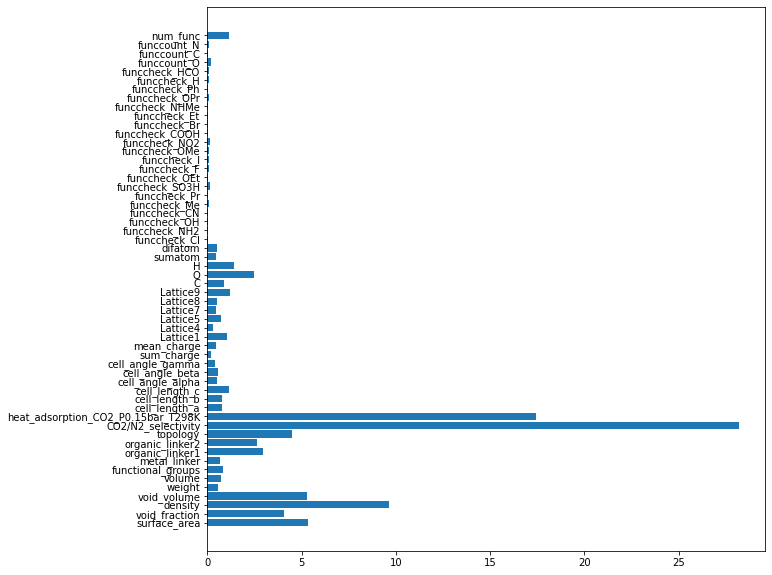

In [68]:
plt.figure(figsize=(10,10))
plt.barh(df_selected.columns, model.feature_importances_);plt.show()

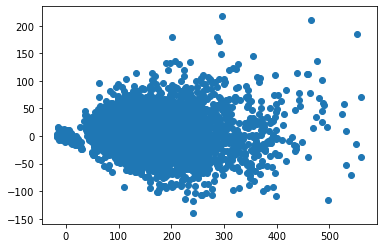

In [69]:
%matplotlib inline
plt.scatter(pred_df[0],pred_df[1]-pred_df[0]);plt.show()

<h1>Evaluation</h1>

In [70]:
testset = pd.read_csv('Datasets/cif_xyz_nonfg_test.csv')
print(testset.shape);testset.head()

(17000, 35)


,volume,density,weight,surface_area,void_fraction,void_volume,functional_groups,metal_linker,organic_linker1,organic_linker2,...,Lattice7,Lattice8,Lattice9,C+O+H,C,O,H,sumatom,mean_charge,sum_charge
0,1208.301332,1.096273,797.70936,586.54,0.11392,0.1039,OEt,2,5,26,...,1.020099,0.251768,17.037858,82,34,14,34,84,-2.380000e-08,-0.000002
1,4126.414623,1.502488,3733.65779,852.49,0.21367,0.1422,H-I,4,6,17,...,-0.093270,-2.770419,27.516247,143,96,26,21,158,3.160000e-08,0.000005
2,1602.148373,0.774443,747.21048,3155.73,0.33883,0.4375,CN-OH,3,11,17,...,-0.039581,0.011104,10.019053,52,30,10,12,60,1.670000e-08,0.000001
3,2436.629312,0.678630,995.80232,3521.09,0.40464,0.5963,OMe,2,1,28,...,-0.463995,0.123045,23.456356,90,46,16,28,94,-4.260000e-08,-0.000004
4,3123.418006,0.711091,1337.53800,2678.46,0.38959,0.5479,NO2-Pr,3,8,19,...,-0.471207,0.882816,16.623692,100,42,28,30,118,-8.470000e-09,-0.000001


In [71]:
testset.functional_groups = testset.functional_groups.astype(str)
testset.metal_linker = testset.metal_linker.astype(str)
testset.organic_linker1 = testset.organic_linker1.astype(str)
testset.organic_linker2 = testset.organic_linker2.astype(str)
testset.topology = testset.topology.astype(str)
testset.head(3)

,volume,density,weight,surface_area,void_fraction,void_volume,functional_groups,metal_linker,organic_linker1,organic_linker2,...,Lattice7,Lattice8,Lattice9,C+O+H,C,O,H,sumatom,mean_charge,sum_charge
0,1208.301332,1.096273,797.70936,586.54,0.11392,0.1039,OEt,2,5,26,...,1.020099,0.251768,17.037858,82,34,14,34,84,-2.380000e-08,-0.000002
1,4126.414623,1.502488,3733.65779,852.49,0.21367,0.1422,H-I,4,6,17,...,-0.093270,-2.770419,27.516247,143,96,26,21,158,3.160000e-08,0.000005
2,1602.148373,0.774443,747.21048,3155.73,0.33883,0.4375,CN-OH,3,11,17,...,-0.039581,0.011104,10.019053,52,30,10,12,60,1.670000e-08,0.000001


In [72]:
compounds = set(['SO3H','COOH','NH2','OH','CN','F','OMe','NHMe','NO2','Pr','Cl','OEt','Ph','Br','OPr','HCO','Et','Me','H','I'])
molecules = set(['N','O','C'])
# molecules = set([])

func_data = {
    f'funccheck_{compound}':check_in(compound,loop=testset.functional_groups)
    for compound in compounds
}
func_data.update({
    f'funccount_{molecule}':count_in(molecule,loop=testset.functional_groups)
    for molecule in molecules
})
func_data.update({
    'num_func': [int('-' in str(x)) for x in testset.functional_groups]
})

testset.functional_groups = testset.functional_groups.astype("category").cat.codes
func_df = pd.DataFrame(func_data);func_df.head(5)

,funccheck_Cl,funccheck_NH2,funccheck_OH,funccheck_CN,funccheck_Me,funccheck_Pr,funccheck_SO3H,funccheck_OEt,funccheck_F,funccheck_I,...,funccheck_Et,funccheck_NHMe,funccheck_OPr,funccheck_Ph,funccheck_H,funccheck_HCO,funccount_O,funccount_C,funccount_N,num_func
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1


In [73]:
testset.insert(
    loc=33,
    column='difatom',
    value=testset['sumatom']-testset['C+O+H']
);df.head(3)

,volume,density,weight,surface_area,void_fraction,void_volume,functional_groups,metal_linker,organic_linker1,organic_linker2,...,Lattice8,Lattice9,C+O+H,C,O,H,sumatom,difatom,mean_charge,sum_charge
0,2769.503842,1.326090,2211.697211,603.61,0.13794,0.1040,115,10,44,57,...,-3.410680,18.641128,173,71,35,67,194,21,5.150000e-09,0.000001
1,1089.818728,1.178856,773.687960,788.50,0.14874,0.1262,303,2,22,24,...,0.148108,10.630959,80,32,14,34,82,2,-3.660000e-08,-0.000003
2,2205.198301,0.982408,1304.638720,1441.53,0.21814,0.2220,139,9,17,24,...,-6.446998,18.164659,107,56,23,28,112,5,4.460000e-08,0.000005


In [74]:
testset = testset[sum(df_col.values(),[])]
testset = pd.concat([testset,func_df],axis=1)
print(df_selected.shape);df_selected.head()

(68584, 56)


,surface_area,void_fraction,density,void_volume,weight,volume,functional_groups,metal_linker,organic_linker1,organic_linker2,...,funccheck_Et,funccheck_NHMe,funccheck_OPr,funccheck_Ph,funccheck_H,funccheck_HCO,funccount_O,funccount_C,funccount_N,num_func
0,603.61,0.13794,1.326090,0.1040,2211.697211,2769.503842,115,10,44,57,...,0,0,0,0,0,0,1,0,0,1
1,788.50,0.14874,1.178856,0.1262,773.687960,1089.818728,303,2,22,24,...,0,0,0,0,0,0,3,1,0,1
2,1441.53,0.21814,0.982408,0.2220,1304.638720,2205.198301,139,9,17,24,...,0,0,0,0,1,0,1,0,0,1
3,2430.55,0.37094,0.647909,0.5725,1543.027680,3954.659761,373,9,7,23,...,0,0,0,0,0,0,1,0,1,1
4,1530.02,0.33337,0.910268,0.3662,1954.749656,3565.914939,200,10,53,55,...,0,0,0,0,0,0,0,0,1,0


Check test set Validation

In [75]:
print(len(testset.columns));print(len(df_selected.columns))
if(len(testset.columns)==len(df_selected.columns)):print(all(testset.columns == df_selected.columns))
else:print(False)

56
56
True


Convert to array

In [76]:
testset_array = np.array(testset);testset.shape

(17000, 56)

Predict

In [77]:
test_pred = model.predict(testset_array);test_pred

array([178.52137244,  53.90294809,  69.41689606, ...,  -0.56603323,
        -2.06560722,  -3.92245335])

Create dataframe

In [78]:
submission = pd.DataFrame({
    "id": [str(i) for i in range(68614,85614)],
    "CO2_working_capacity [mL/g]":test_pred
    })
submission.head()

,id,CO2_working_capacity [mL/g]
0,68614,178.521372
1,68615,53.902948
2,68616,69.416896
3,68617,60.349620
4,68618,59.995107


Save csv

In [79]:
submission.to_csv('submission.csv',index=False,float_format='%.7f')

---